# Import libraries

In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


# Trajectories modeled as neural networks

In [3]:
# Design the neural network
def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    # fhat.add(Dense(50))
    # fhat.add(Dense(20, activation="sigmoid", input_dim=50))
    fhat.add(Dense(1))
    return fhat

x = createTraj()
y = createTraj()
v = createTraj()
th = createTraj()

# Compute loss function

In [4]:
T0 = 0
Tf = 1
nPts = 20
T = tf.cast(tf.linspace(0,Tf,nPts),dtype=tf.float32)

def errors(t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        X = x(t)
        Y = y(t)
    
    Xd = tape.gradient(X,t)
    Yd = tape.gradient(Y,t)

    TH = th(t)
    V  = v(t)
    
    # Error in dynamics
    e_xdot = tf.reduce_sum((tf.reshape(Xd,shape=(nPts,1)) - V*tf.cos(TH))**2)
    e_ydot = tf.reduce_sum((tf.reshape(Yd,shape=(nPts,1)) - V*tf.sin(TH))**2)

    # Error in initial condition
    x0 = 0; y0 = 0;
    eIC = (X[0] - x0)**2  + (Y[0] - y0)**2  + (TH[0]-pi/2)**2 + V[0]**2 # start from (x0,y0) at rest and pointing east

    # Error in final condition
    xf = 1; yf = 1;
    eFC = (X[-1] - xf)**2 + (Y[-1] - yf)**2 + (TH[-1]-pi/2)**2 + V[-1]**2 # end at (xf,yf) at rest and pointing west 
    
    return e_xdot + e_ydot + 10*eIC + 10*eFC 

# Train the network

In [5]:
run_counter = -1
while errors(T) >= 0.001:
    nIter = 500
    run_counter += 1
    if run_counter == 20:
        print('Failed to converge')
        break
    if errors(T) <= 1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    elif errors(T) <= 0.5:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    elif errors(T) <= 0.1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    elif errors(T) <= 0.01:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
    for i in tqdm(range(nIter),desc=f"Training run {run_counter}"):
        with tf.GradientTape(persistent=True) as tape:
            e = errors(T)
        if e <= 0.001:
            print('Finish Training')
            break
        # if i%50 == 0:    
            # print(f'iter: {i}, error: {e[0]}')
    
        # Update parameters in x
        grads = tape.gradient(e, x.trainable_variables)
        optimizer.apply_gradients(zip(grads, x.trainable_variables))

        # Update parameters in y
        grads = tape.gradient(e, y.trainable_variables)
        optimizer.apply_gradients(zip(grads, y.trainable_variables))

        # Update parameters in v
        grads = tape.gradient(e, v.trainable_variables)
        optimizer.apply_gradients(zip(grads, v.trainable_variables))

        # Update parameters in th
        grads = tape.gradient(e, th.trainable_variables)
        optimizer.apply_gradients(zip(grads, th.trainable_variables))
    print(f"Last error: {round(float(errors(T)[0]),4)}")

Training run 0:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.4938


Training run 1:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0557


Training run 2:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0132


Training run 3:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0086


Training run 4:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0065


Training run 5:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0053


Training run 6:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.005


Training run 7:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0049


Training run 8:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0046


Training run 9:   0%|          | 0/500 [00:00<?, ?it/s]

Last error: 0.0044
Failed to converge


# Plot the results

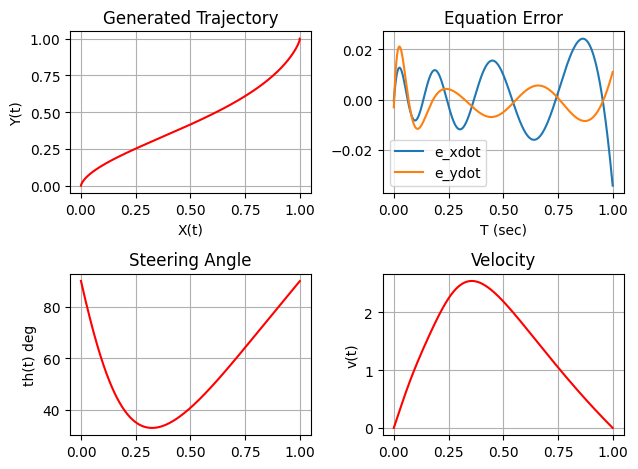

In [6]:
import matplotlib.pyplot as plt

nPts1 = 1000
TT = tf.cast(tf.linspace(0,Tf,nPts1),dtype=tf.float32)
tt = TT.numpy()

with tf.GradientTape(persistent=True) as tape:
    tape.watch(TT)
    X = x(TT)
    Y = y(TT)
    
Xd = tape.gradient(X,TT)
Yd = tape.gradient(Y,TT)

e_xdot = tf.reshape(Xd,shape=(nPts1,1)) - v(TT)*tf.cos(th(TT))
e_ydot = tf.reshape(Yd,shape=(nPts1,1)) - v(TT)*tf.sin(th(TT))


r2d = 180/pi

plt.subplot(2,2,1); plt.plot(X.numpy(),Y.numpy(),'r'); plt.grid('on'); plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Generated Trajectory') 
plt.subplot(2,2,2); plt.plot(tt,e_xdot,label='e_xdot'); plt.grid('on'); plt.title('Equation Error'); plt.xlabel('T (sec)') 
plt.subplot(2,2,2); plt.plot(tt,e_ydot,label='e_ydot'); plt.grid('on'); 
plt.legend()

plt.subplot(2,2,3); plt.plot(tt,th(TT).numpy()*r2d,'r'); plt.grid('on');plt.ylabel('th(t) deg'); plt.title('Steering Angle')
plt.subplot(2,2,4); plt.plot(tt,v(TT).numpy(),'r'); plt.grid('on');plt.ylabel('v(t)'); plt.title('Velocity')
plt.tight_layout()
